In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import jv
from scipy.interpolate import interp1d
from numpy.typing import NDArray

In [2]:
h = 6.62607015e-34  # V * A * s²
e = 1.602176634e-19 #     A * s
Vgap = 189e-6       # V
Delta = Vgap*e      # V * A * s
G_0 = 2*e**2/h      # A / V
R_0 = h/(2*e**2)    # V / A
nu = 15e9           # 1 / s

# Tien Gordon Model
$$
I(\tau_i, V_0, V_\nu) = \sum_{\tau_i} \sum_{n=-N}^N J_n^2\left(\frac{eV_\nu}{h\nu}\right) \cdot I_0 \left(\tau_i, \frac{eV_0}{\Delta} - n\cdot\frac{h\nu}{\Delta} \right)
$$

In [3]:
def get_Tien_Gordon(
        V_nu: NDArray[np.float64],
        pincode: NDArray[np.float64],
        nu: float,
        model: str = 'CarlosIV',
        V_gap: float = 189e-6,
        N:int = 400,
        ):
    
    # constants
    h = 6.62607015e-34  # V * A * s²
    e = 1.602176634e-19 #     A * s
    Delta = V_gap * e   # V * A * s
    
    # models
    models = ['CarlosIV', 'DavidOIV']
    match model:
        case 'CarlosIV':
            with open("CarlosIV/CarlosIV.pickle", "rb") as file:
                IVs = pickle.load(file)
        case 'DavidOIV':
            with open("DavidOIV/DavidOIV.pickle", "rb") as file:
                IVs = pickle.load(file)
        case _:
            raise KeyError (f"Unknown model, Expected: {models}")
        
    tau = IVs['tau']
    tau_indices = np.zeros(np.shape(pincode), dtype='int')
    for i, pin in enumerate(pincode):
        tau_indices[i] = np.argmin(np.abs(tau-pin))
        if np.nanmin(np.abs(tau-pin)) != 0:
            print(f'pincode entry {pin} is approximated with {tau_indices[i]}.')

    # Tien Gordon
    V_0 = IVs['V']
    I_TG = np.full((V_nu.shape[0], V_0.shape[0]), 0, dtype='float64')

    # sum over channels
    for index, tau_index in enumerate(tau_indices):
        I_0 = IVs['I'][tau_index, :]
        I_0[np.isnan(I_0)]=0.
        interpolated_I = interp1d(
            V_0, 
            I_0, 
            kind='linear', 
            bounds_error=False, 
            fill_value='extrapolate',
            )
        
        # sum over photons
        for n in range(-N, N+1):
            # Bessel function squared (n)
            J_n_2 = jv(n, V_nu)**2

            # Shift I_0 by n
            V_n = n*h*nu/(Delta)
            I_n = interpolated_I(V_0 - V_n)

            # Calculate the n'th current 
            I_n, J_n_2 = np.meshgrid(I_n, J_n_2)

            # Sum up current
            I_TG += J_n_2 * I_n
        
    return V_0, I_TG        
    

V_0, I_TG = get_Tien_Gordon(
        V_nu = np.linspace(0, 25, 401, dtype='float64'),
        pincode=np.array([ 0.1, .005]),
        nu = 15e9,
        model='DavidOIV',
    )


pincode entry 0.005 is approximated with 0.


# PAMAR
$$
I(\tau_i, V_0, V_\nu) = \sum_{\tau_i} \sum_{m=1}^M \sum_{n=-N}^N J_n^2\left(m \cdot \frac{eV_\nu}{h\nu}\right) \cdot I_{0} \left(\tau_i, m, \frac{eV_0}{\Delta} - \frac{n}{m}\cdot\frac{h\nu}{\Delta} \right)
$$

In [40]:
def get_PAMAR(
        V_nu: NDArray[np.float64],
        pincode: NDArray[np.float64],
        nu: float,
        model: str = 'DavidOIV',
        V_gap: float = 189e-6,
        N: int = 20,
        M: int = 19,
        ):
    
    # constants
    h = 6.62607015e-34  # V * A * s²
    e = 1.602176634e-19 #     A * s
    Delta = V_gap * e   # V * A * s
    
    # models
    models = ['DavidOIV']
    match model:
        case 'DavidOIV':
            with open("DavidOIV/DavidOIV.pickle", "rb") as file:
                IVs = pickle.load(file)
        case _:
            raise KeyError (f"Unknown model, Expected: {models}")
        
    tau = IVs['tau']
    tau_indices = np.zeros(np.shape(pincode), dtype='int')
    for i, pin in enumerate(pincode):
        tau_indices[i] = np.argmin(np.abs(tau-pin))
        if np.nanmin(np.abs(tau-pin)) != 0:
            print(f'pincode entry {pin} is approximated with {tau_indices[i]}.')

    # Tien Gordon
    V_0 = IVs['V']
    I_TG = np.full((V_nu.shape[0], V_0.shape[0]), 0, dtype='float64')

    # sum over channels
    for index, tau_index in enumerate(tqdm(tau_indices)):
        I_0_m = IVs['I_m'][tau_index, :]
        I_0_m[np.isnan(I_0_m)]=0.

        # sum over charges
        for i_m, m in enumerate(np.arange(1, M+1)):

            # define interpolate
            I_m_ip = interp1d(
                V_0, 
                I_0_m[i_m], 
                kind='linear', 
                bounds_error=False, 
                fill_value='extrapolate',
                )

            # sum over photons
            for i_n, n in enumerate(np.arange(-N,N+1)):

                # Bessel function squared (n)
                J_n_m_2 = jv(n, m*V_nu)**2

                # Shift I_0 by n/m
                V_n_m = n/m*h*nu/Delta
                I_n_m = I_m_ip(V_0 + V_n_m)

                # Calculate the n'th current 
                I_n_m, J_n_m_2 = np.meshgrid(I_n_m, J_n_m_2)

                # Sum up current
                I_TG += I_n_m * J_n_m_2
        
    return V_0, I_TG, IVs

In [57]:
  
pincode = np.array([.5, .35, .28, .25, .25, .25])
# pincode = np.array([0.01, 0.25, 0.325, 0.62, 0.8])
pincode = np.array([.5])
V_nu = np.linspace(0, 25, 401, dtype='float64')
nu = 15e9
M=20
N=40

V_0, I_PAMAR, IVs = get_PAMAR(
        V_nu = V_nu,
        pincode=pincode,
        nu = nu,
        model='DavidOIV',
        M=M, N=N,
    )
V_0, I_TG = get_Tien_Gordon(
        V_nu = V_nu,
        pincode=pincode,
        nu = nu,
        model='DavidOIV',
        N=N,
    )

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


In [ ]:
%matplotlib qt
import matplotlib.gridspec as gridspec

plt.close('all')

fig = plt.figure(figsize=(6,4))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[2, 2, .2])
ax_TG = fig.add_subplot(gs[0])
ax_PAMAR = fig.add_subplot(gs[1])
cax = fig.add_subplot(gs[2])
c=2
z0 = np.gradient(I_TG, V_0, axis=1)
z1 = np.gradient(I_PAMAR, V_0, axis=1)
z = np.concatenate((z0, z1))
clim = (np.nanmean(z)-np.nanstd(z)*c, np.nanmean(z)+np.nanstd(z)*c)
im = ax_TG.imshow(z0, 
           extent=(V_0[0], V_0[-1], V_nu[0], V_nu[-1]),
           clim = clim,
           aspect='auto', origin='lower',
           interpolation=None)
ax_PAMAR.imshow(z1, 
           extent=(V_0[0], V_0[-1], V_nu[0], V_nu[-1]),
           clim = clim,
           aspect='auto', origin='lower',
           interpolation=None)

fig.colorbar(im, cax=cax, label=r'd$I/$d$V$ ($G_0$)')
ax_TG.set_ylabel(r'$eV_\nu$ (arb. units)')
ax_TG.set_xlabel(r'$eV_0$ ($\Delta$)')
ax_PAMAR.set_xlabel(r'$eV_0$ ($\Delta$)')
ax_PAMAR.set_yticks([])

ax_TG.set_title('Tien Gordon')
ax_PAMAR.set_title(f'PAMAR ($M={M}$)')

fig.suptitle(rf'$\tau_i$ = {pincode}, $\nu = {nu*1e-9:.02f}\,$GHz')

y_lim = (0, 7)
ax_TG.set_ylim(y_lim)
ax_PAMAR.set_ylim(y_lim)

(0.0, 7.0)

In [239]:
np.arange(1, 20)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [128]:
range(20)

range(0, 20)

In [181]:
np.arange(1,2)

array([1])

In [80]:
# Load the data
file = "iv_0.05.dat"
eV_bias, I_0 = np.loadtxt(file, unpack=True)

eV_bias = np.concatenate((-np.flip(eV_bias), eV_bias))
I_0 = np.concatenate((-np.flip(I_0), I_0))

dIdV_0 = np.gradient(I_0, eV_bias)
eV_omega = np.linspace(0, 25, 401)

FileNotFoundError: iv_0.05.dat not found.

In [ ]:



dIdV_TG = np.zeros((len(eV_omega), len(eV_bias)))
I_TG = np.zeros((len(eV_omega), len(eV_bias)))

# Interpolate I_0 to match the eV_bias
interpolated_I = interp1d(eV_bias, I_0, kind='linear', bounds_error=False, fill_value='extrapolate')
interpolated_dIdV = interp1d(eV_bias, dIdV_0, kind='linear', bounds_error=False, fill_value='extrapolate')

N = 400
for n in range(-N, N+1):
    # Bessel function squared (n)
    J_n_2 = jv(n, eV_omega)**2

    # Shifted I_0
    eV_n = n*h*nu/(Delta)
    I_n = interpolated_I(eV_bias - eV_n)
    dIdV_n = interpolated_dIdV(eV_bias - eV_n)

    # plt.plot(eV_bias, dIdV_n)

    # # Calculate the current
    I_n, _ = np.meshgrid(I_n, J_n_2)
    dIdV_n, J_n_2 = np.meshgrid(dIdV_n, J_n_2)

    I_TG += J_n_2 * I_n
    dIdV_TG += J_n_2 * dIdV_n

NameError: name 'eV_omega' is not defined

In [85]:
from scipy.integrate import cumulative_trapezoid
# Integrate dI/dV to get I(V)
z = cumulative_trapezoid(dIdV_TG, eV_bias, initial=0)  # initial=0 sets I(V[0]) = 0
z = np.gradient(I_TG, eV_bias, axis=1)

NameError: name 'dIdV_TG' is not defined

Text(0.5, 0, '$eV_0$ ($\\Delta$)')

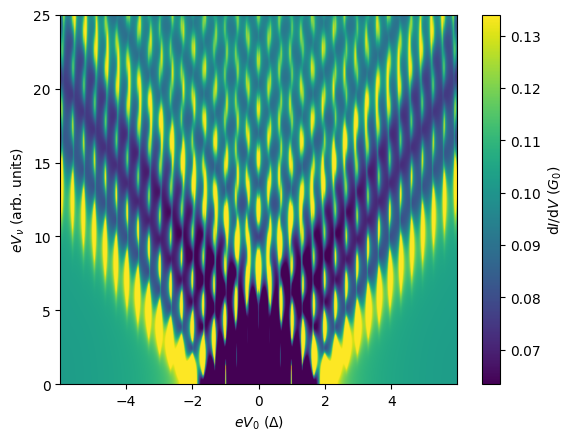

In [120]:
z = np.gradient(I_TG, V_0, axis=1)
clim = (np.nanmean(z)-np.nanstd(z), np.nanmean(z)+np.nanstd(z))
plt.imshow(z, 
           extent=(V_0[0], V_0[-1], V_nu[0], V_nu[-1]),
           clim = clim,
           aspect='auto', origin='lower',
           interpolation=None)
plt.colorbar(label=r'd$I/$d$V$ ($G_0$)')
plt.ylabel(r'$eV_\nu$ (arb. units)')
plt.xlabel(r'$eV_0$ ($\Delta$)')